# Lib imports

In [1]:
import yfinance as yf
import cvxpy as cp
import pypfopt as pypf
import matplotlib.pyplot as plt
from pypfopt import plotting

# Intro

Portfolio optimization is a critical tool for modern investors willing to maximize their capital utilization in the market and expected returns. 

Many portfolio optimization techniques are based on different variants of constrained quadratic programming formalizations, taking as inputs expected asset returns, forms of risk metrics (like covariance matrices), and transaction costs. Next, the goal is selected (typically a maximization of return while keeping the risk level constant or minimizing the risk with varying returns ). The problem is solved either via a closed-form equation or a gradient-minimizing approach. Additional elements or steps can be included, like periodical rebalancing, the inclusion of transaction costs, or different cost functions (Sharpe ratio or similar). 

This blog post will show you how to prepare and perform a simple portfolio optimization process on selected stocks. Two approaches will be utilized - purely mathematical formulation of the optimization problem and PyPorfolioOpt library that automates most of the process. 

After reading this article, you will know the following:
1. Key terms like portfolio, portfolio weights, and Markovitz model.
1. How to prepare stock price data for portfolio optimization task using **yfinance** library.
2. How to formulate the problem in terms of the optimization task.
3. How to solve the optimization problem using the  library **cvxpy** and dedicated **PyPortfolioOpt**.

# Portfolio
The first important thing is to define what a portfolio is. In layperson's terms, the portfolio is a set of different assets (stocks, bonds, etc. - in general: different financial instruments) (Luenberger, 1997). Typically investors seek diversification of capital, so they want to have various types of assets.

Portfolio optimization is finding optimal asset weights so that the portfolio return (final return after some investment period) is maximized in terms of the selected function.

# Financial time series

## Data prep

The portfolio optimization process starts with stock prices. You need to download historical prices for a specific period and instruments you are interested in. 
For this purpose, we will utilize a yahoo finance (yf) library, an unofficial tool for downloading prices from Yahoo! Finance 

[Library link](https://github.com/ranaroussi/yfinance)

In [2]:
# Step 1: let's pick some well-known stocks
stocks = ['AAPL', 'GOOG', 'MSFT']
start_date = '2020-01-01'

# Step 2: download prices from Yahoo!
all_prices = yf.download(stocks, start=start_date)

all_prices.head(3)

[*********************100%***********************]  3 of 3 completed


Adj Close                             Close             \
                 AAPL       GOOG        MSFT       AAPL       GOOG   
Date                                                                 
2020-01-02  73.561539  68.368500  156.591980  75.087502  68.368500   
2020-01-03  72.846382  68.032997  154.642151  74.357498  68.032997   
2020-01-06  73.426834  69.710503  155.041855  74.949997  69.710503   

                             High                               Low  \
                  MSFT       AAPL       GOOG        MSFT       AAPL   
Date                                                                  
2020-01-02  160.619995  75.150002  68.406998  160.729996  73.797501   
2020-01-03  158.619995  75.144997  68.625000  159.949997  74.125000   
2020-01-06  159.029999  74.989998  69.824997  159.100006  73.187500   

                                        Open                         \
                 GOOG        MSFT       AAPL       GOOG        MSFT   
Date                                                                  
2020-01-02  67.077499  158.330002  74.059998  67.077499  158.779999   
2020-01-03  67.277199  158.059998  74.287498  67.392998  158.320007   
2020-01-06  67.500000  156.509995  73.447502  67.500000  157.080002   

               Volume                      
                 AAPL      GOOG      MSFT  
Date                                       
2020-01-02  135480400  28132000  22622100  
2020-01-03  146322800  23728000  21116200  
2020-01-06  118387200  34646000  20813700

For the sake of this exercise, we will utilize only "Close" prices for each asset.

In [3]:
close_prices = all_prices['Close']
close_prices.head(3)

,AAPL,GOOG,MSFT
Date,,,
2020-01-02,75.087502,68.368500,160.619995
2020-01-03,74.357498,68.032997,158.619995
2020-01-06,74.949997,69.710503,159.029999


Now we have a matrix of real numbers of shape ``T x A``, 

where T - is the number of time steps and A is the number of assets in the portfolio. 

## Returns

Raw prices cannot be used for portfolio optimization. One needs to calculate the returns - price changes. There are two main forms of returns calculation (Dees & Sidier, 2019):
1. **Gross returns** - the price at time t, divided by the price at time t-1.
$$
\begin{align}
R_t &\doteq \frac{p_t}{p_{t-1}} \in \mathbb{R} \tag{1a} \\
\end{align}
$$
2. **Simple returns** - percentage change of price between t-1 and t.
$$
\begin{align}
r_t &\doteq \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1 = R_t - 1 \in \mathbb{R} & \tag{1b} \\
\end{align}
$$
3. **Log returns**  - a log of simple returns used to avoid computational underflows.
$$\begin{align}
p_t &\doteq \ln(R_t) \in \mathbb{R} & \tag{1c} \\
\end{align}
$$
Here we will utilize simple returns `(1a)`, as they are easily interpretable 

In [4]:
returns = close_prices.pct_change().dropna()
returns.head(3)

,AAPL,GOOG,MSFT
Date,,,
2020-01-03,-0.009722,-0.004907,-0.012452
2020-01-06,0.007968,0.024657,0.002585
2020-01-07,-0.004703,-0.000624,-0.009118


# Portfolio optimization

## Porttfolio weights

In this context, a portfolio is defined as a set of asset weights vector such that (Kolm et al., 2014):

$$
\begin{align}
\bf{\omega} = \left[\omega_1, \omega_2, \dots, \omega_A \right]^T,\quad \sum_{i=1}^A \omega_i = 1 \tag{2}
\end{align}
$$

where each $\omega_i$  is a weight of the i-th asset in the portfolio.
One might have, e.g., 20% of Apple stocks, 40% of Google Stocks, and 40% of Microsoft stocks. Therefore `[0.2, 0.4, 0.2]` is a set of portfolio weights.


**Annualized, average asset returns** (mean returns multiplied by trading days), weighted by $\omega$, constitute the portfolio returns. Formally:

$$\mu ^T \bf{\omega}$$


## Theoretical foundation

The portfolio **Mean-Variance optimization** problem can be defined as a constrained linear model as follows  (Capinski Marek & Zastawniak Tomasz, 2011; Kennedy, 2016; Kolm et al., 2014):
1. The formulation as maximization problem: maximize portfolio returns while keeping variance below maximal level $\sigma_{max}^2$
$$\begin{align}
&\max_{\omega \in \Omega} \omega^T\mu & \tag{3a}\\
&\text{Subject to:} \\
&& \omega^T \Sigma \omega \le \sigma^2_{max} \\
&& \sum \omega  = 1
\end{align}
$$
2. The formulation as minimization problem: minimize portfolio variance while achieving at least minimal desired portfolio returns $R_min$:
$$\begin{align}
& \min_{\omega \in \Omega} \omega^T \Sigma \omega  & \tag{3b}\\
& \text{Subject to:} \\
&&  \omega^T\mu \ge R_{min} \\
&& \sum \omega  = 1
\end{align}
$$

Where $\mu = \begin{bmatrix}\mu_1 \\ \mu_2 \\ \dots \\ \mu_A\end{bmatrix}, \forall_i \mu_i \in \mathbb{E}[r_i]$ is a vector of **annualized** (multiplied by trading days, usually 252) expected securities return and $\Omega$ is a universe of all possible portfolio weights combinations. $\Sigma$ is the **annualized** (multiplied by trading days, usually 252) asset returns covariance matrix, where $\sigma_i$ is the standard deviation of returns $r_i$ (Capinski Marek & Zastawniak Tomasz, 2011; Kolm et al., 2014):

$$
\Sigma = \begin{bmatrix}
\sigma_{1,1} & \sigma_{2,1} & \dots & \sigma_{A,1}\\
\sigma_{1,2} & \sigma_{2,2} & \dots & \sigma_{A,2}\\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{1,T} & \sigma_{2,T} & \dots & \sigma_{A,T}\\
\end{bmatrix}
$$

## "Vanilla" model extensions

One of the typically used modifications to the baseline model is the **"risk aversion"** parameter, defining the degree to which the investor is willing to balance the risk level with expected returns (Wilmott, 2007). With this aversion parameter, the model is formalized as the following optimization problem (Dees & Sidier, 2019; Kolm et al., 2014):

$$\begin{align}
&\max_{\omega \in \Omega} \omega^T\mu - \alpha \omega^T\Sigma\omega & \tag{4a}\\
&\text{Subject to:} \\
&& \omega \ge 0 \\
&& \sum \omega  = 1
\end{align}
$$

Additionally, several objective functions can be selected as the optimization goal. One of the most interpretable ones is the utilization of the **Sharpe Ratio** (Sharpe, 1966, 1994), defined as the **reward-to-variability ratio**. Formally (Dees & Sidier, 2019; Goetzmann et al., 2014):

$$
\begin{align}
SR = \frac{\mu - R_f}{\sigma_p} \tag{4b}
\end{align}
$$

Where $\mu$ is expected assets returns (as defined above), $R_f$ is the **risk-free rate (often set to zero or defined as the returns from the safest financial instrument on the market - e.g. state-issued bonds)**, and $\sigma_p$ is a standard deviation of portfolio returns $\sqrt{\omega^T \Sigma \omega}$.
When used as the objective function in the Markowitz model, the optimization problem is formalized (Dees & Sidier, 2019; Wilmott, 2007):

$$\begin{align}
&\max_{\omega \in \Omega} \frac{\omega^T\mu}{\sqrt{\omega^T \Sigma \omega}} & \tag{4c}\\
&\text{Subject to:} \\
&& \omega \ge 0 \\
&& \sum \omega  = 1
\end{align}
$$

## Efficient frontier

Different weights produce different portfolios varied in terms of returns and variance. An analyst can plot these portfolios on a chart where the x-axis represents variance, and the y-axis represents returns. 

Portfolios are considered "efficient" if they (Stoilova 2020; Luenberger 1997):

1. For a given return (point on the y-axis), offer the lowest possible variance;
2. For a given variance (point on the x-axis) offer the highest possible returns. 

Therefore efficient frontier is the line connecting the outermost points on the chart.

![convert notebook to web app](Minimum_variance_flontier_of_MPT.svg)

[Image source](https://commons.wikimedia.org/wiki/File:Minimum_variance_flontier_of_MPT.svg)


# Python code

## Vanilla optimization - CVXPY
Let's try to port the **"vanilla Markowitz"** equations (3b) - risk minimization given expected return, directly to the Python code.

$$\begin{align}
& \min_{\omega \in \Omega} \omega^T \Sigma \omega  & \tag{3b}\\
& \text{Subject to:} \\
&&  \omega^T\mu \ge R_{min} \\
&& \sum \omega  = 1
\end{align}
$$

For this purpose, we will utilize the **CVXPY optimization library** - a powerful tool for solving linear programming and constraint optimization problems. 

[Link to documentation and tutorials](https://www.cvxpy.org/).

In [5]:
# Annualized mean returns and covariance: mean returns * trading days, cov matrix * trading days
mu = returns.mean() * 252
cov_mat = returns.cov() * 252

# constraint - minmal expected return
min_ret = 0.24

# Direct implementation of equation 3b
# variable to be optimized - portfolio weights
w = cp.Variable(shape=mu.shape, nonneg=True)

# An objective function to be minimized
objective_min_risk = cp.quad_form(w, cov_mat)

# List of constraints
constraints = [
    cp.sum(w) == 1,
    (mu.values @ w) >= min_ret
]

# Problem definition and solution
min_risk_problem = cp.Problem(cp.Minimize(objective_min_risk), constraints=constraints)
min_risk_problem.solve()

# Final weights
print(w.value.round(3))

[0.421 0.398 0.181]


Let's check the total portfolio return by calculating a dot-product between weights and annualized mean returns:

In [10]:
(mu @ w.value).round(3)

0.24

## Risk aversion - CVXPY

Let's try to implement directly in CVXPY equation `(4b)` - maximization of returns with risk aversion.


$$\begin{align}
&\max_{\omega \in \Omega} \omega^T\mu - \alpha \omega^T\Sigma\omega & \tag{4a}\\
&\text{Subject to:} \\
&& \omega \ge 0 \\
&& \sum \omega  = 1
\end{align}
$$

Let's try to solve it for $\alpha = 0.2$

In [7]:
# Annualized mean returns and covariance: mean returns * trading days, cov matrix * trading days
mu = returns.mean() * 252
cov_mat = returns.cov() * 252
alpha = 0.2
# Risk aversion parameter, example value

# Direct implementation of equation 3b
# variable to be optimized - portfolio weights
w_risk_av = cp.Variable(shape=mu.shape, nonneg=True)

# An objective function to be maximized
objective_risk_av = (mu.values @ w_risk_av) - cp.multiply(alpha, cp.quad_form(w_risk_av, cov_mat))

# List of constraints
constraints = [
    cp.sum(w_risk_av) == 1,
    w_risk_av >= 0
]

# Problem definition and solution
max_return_risk_av_problem = cp.Problem(cp.Maximize(objective_risk_av), constraints=constraints)
max_return_risk_av_problem.solve()

# Final weights
print(w_risk_av.value.round(5))

[1. 0. 0.]


It seems that the portfolio that maximizes returns, given the risk-aversion parameter, consists solely of Apple.

## PyPortfolioOpt

Python library **PyPortfolioOpt** automates most of the operations we have done above. It contains additional features like:
1. **Multiple risk calculations** in the form of a plug-in function - an analyst can choose from a simple covariance matrix or more advanced calculations.
2. **Multiple target functions** - including maximization of returns given some acceptable risk, minimization of risk given desired return, Sharpe ratio, etc.
3. **Automatic option to validate portfolio** in-sample (using "training data," on which optimization was done).

Let's try to replicate the calculations from CVXPY.

### PyPf - The "vanilla scenario"

In [8]:
# Set min desired return. Same as in the CVXPY case
min_return = 0.24

# Step 1: Calculate expected returns using library. Compunding=False uses simple average
mu_pypf = pypf.expected_returns.mean_historical_return(close_prices, compounding=False)

# Step 2: Calculate covariance matrix from prices. 
cov_pypf = pypf.risk_models.sample_cov(close_prices)

# Step 3: Prepare efficient frontier for calculations.
ef_vanilla = pypf.efficient_frontier.EfficientFrontier(mu_pypf, cov_pypf)

# Step 4: Choose the objective funciton.
ef_vanilla.efficient_return(min_return)

# Step 5: Get 'clean weights' - rounded and cleaned from near-zero values
ef_vanilla.clean_weights()

OrderedDict([('AAPL', 0.42125), ('GOOG', 0.39782), ('MSFT', 0.18093)])

The function to measure portfolio performance will give us:
1. Total portfolio returns
2. Volatility
3. Sharpe ratio

Let's check:

In [11]:
total_returns, volatility, sharpe = ef_vanilla.portfolio_performance()
print(f"Total ret: {total_returns:.2f}, volatility: {volatility:.2f}, Sharpe ratio: {sharpe:.2f}")

Total ret: 0.24, volatility: 0.33, Sharpe ratio: 0.67


Portfolio return is aligned with our manual calculations from pure optimization approach.

### PyPf - risk aversion scenario

In [12]:
# Set risk aversion parameter as before.
alpha = 0.2

# Step 1: Calculate expected returns using library. Compunding=False uses simple average
mu_pypf = pypf.expected_returns.mean_historical_return(close_prices, compounding=False)

# Step 2: Calculate covariance matrix from prices. 
cov_pypf = pypf.risk_models.sample_cov(close_prices)

# Step 3: Prepare efficient frontier for calculations.
ef_risk_av = pypf.efficient_frontier.EfficientFrontier(mu_pypf, cov_pypf)

# Step 4: Choose the objective funciton.
ef_risk_av.max_quadratic_utility(risk_aversion=alpha)

# Step 5: Get 'clean weights' - rounded and cleaned from near-zero values
ef_risk_av.clean_weights()

OrderedDict([('AAPL', 1.0), ('GOOG', 0.0), ('MSFT', 0.0)])

Again - results are aligned with manual calculation from CVXPY.

# Efficient frontier in Python

The library PyPorfolioOpt can produce Efficient Frontier plots as well. Once the target function has been selected, one can see different efficient frontier visualizations with possible asset configurations placed on the risk-reward scale.

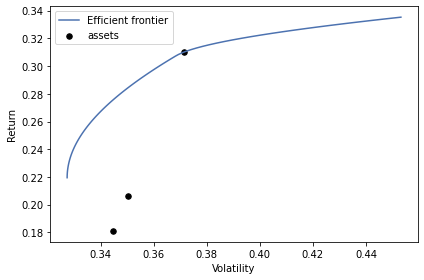

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

In [13]:
# Step 1: construct a new efficient frontier BEFORE calculating expected weights
ef = pypf.EfficientFrontier(mu_pypf, cov_pypf, weight_bounds=(None, None))

# Step 2: Choose what type of efficient frontier to plot: risk/return/utility?
plotting.plot_efficient_frontier(
    ef, 
    ef_param="return",
    show_assets=True, 
    showfig=True)

# Summary

Here is a brief summary of what topics were covered in this post:

1. A portfolio is a set of assets/financial instruments that hold some value;
2. These assets can have different weights, contributing to the total reward by the end of the period;
3. The process of finding optimal weights (concerning some constraints and objectives - below) is called portfolio optimization;
4. As the name suggests - this process (in its basic form) is a constrained linear programming problem;
5. One of the best-known tools for solving such problems is called the "Markovitz model", which either:
    1. minimizes risk for predefined minimal return;
    2. maximizes return while trying to keep the risk below the maximally accepted level;
6. Various portfolio compositions can be plotted using efficient frontier - on the risk-reward scale;
7. Such problems can be solved in Python either:
    1. using optimization libraries like CVXPY;
    2. Using specialized libraries for portfolio optimization, like PyPortfolioOpt.

# Bibliography

1. **Capinski Marek, & Zastawniak Tomasz**. (2011). Mathematics for Finance. Springer London.
2. **Dees, B. S., & Sidier, G**. (2019). Reinforcement Learning for Portfolio Management. https://doi.org/10.48550/arxiv.1909.09571
3. **Goetzmann, W. N., Brown, S. J., Gruber, M. J., & Elton, E. J.** (2014). Modern portfolio theory and investment analysis. John Wiley & Sons, 237.
4. **Kennedy, D.** (2016). Stochastic financial models. CRC Press.
5. **Kolm, P. N., Tütüncü, R., & Fabozzi, F. J.** (2014). 60 Years of portfolio optimization: Practical challenges and current trends. European Journal of Operational Research, 234(2). https://doi.org/10.1016/j.ejor.2013.10.060
5. **Luenberger, D. G.** (1997). Investment science. Oxford Univ. Press.
6. **Sharpe, W. F.** (1966). Mutual fund performance. The Journal of Business, 39(1), 119–138.
7. **Sharpe, W. F.** (1994). The Sharpe Ratio, the journal of Portfolio Management. Stanfold University, Fall.
8. **Stoilov, T., Stoilova, K., & Vladimirov, M.** (2020). Analytical overview and applications of modified black-litterman model for portfolio optimization. Cybernetics and Information Technologies, 20(2). https://doi.org/10.2478/cait-2020-0014
8. **Wilmott, P.** (2007). Paul Wilmott introduces quantitative finance. John Wiley & Sons.